In [1]:
library(repr)
library(tidyr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
install.packages("kknn")
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ dplyr   1.1.1
✔ tibble  3.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
✔ purrr   1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ rec

Graphs we could use: bar-(for analyzing data. 2 bars: The correct prediction and the wrong prediction) In the procedures: include graph(accuracy vs. K neighbors)

### Obtain the Data

In [2]:
fetal_health_data <- read_csv("https://raw.githubusercontent.com/wonha0620/dsci_100_proj/main/fetal_health.csv")
head(fetal_health_data)

Rows: 2126 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): baseline value, accelerations, fetal_movement, uterine_contraction...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,⋯,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
120,0.000,0,0.000,0.000,0,0.000,73,0.5,43,⋯,62,126,2,0,120,137,121,73,1,2
132,0.006,0,0.006,0.003,0,0.000,17,2.1,0,⋯,68,198,6,1,141,136,140,12,0,1
133,0.003,0,0.008,0.003,0,0.000,16,2.1,0,⋯,68,198,5,1,141,135,138,13,0,1
134,0.003,0,0.008,0.003,0,0.000,16,2.4,0,⋯,53,170,11,0,137,134,137,13,1,1
132,0.007,0,0.008,0.000,0,0.000,16,2.4,0,⋯,53,170,9,0,137,136,138,11,1,1
134,0.001,0,0.010,0.009,0,0.002,26,5.9,0,⋯,50,200,5,3,76,107,107,170,0,3


### Wrangling the Data

In [3]:
health_data_clean <- fetal_health_data |>
    # select(`baseline value`:mean_value_of_long_term_variability, fetal_health) |>
    mutate(fetal_health = as_factor(fetal_health))
colnames(health_data_clean) <- gsub(" ", "_", colnames(health_data_clean))
head(health_data_clean)

baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,⋯,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
120,0.000,0,0.000,0.000,0,0.000,73,0.5,43,⋯,62,126,2,0,120,137,121,73,1,2
132,0.006,0,0.006,0.003,0,0.000,17,2.1,0,⋯,68,198,6,1,141,136,140,12,0,1
133,0.003,0,0.008,0.003,0,0.000,16,2.1,0,⋯,68,198,5,1,141,135,138,13,0,1
134,0.003,0,0.008,0.003,0,0.000,16,2.4,0,⋯,53,170,11,0,137,134,137,13,1,1
132,0.007,0,0.008,0.000,0,0.000,16,2.4,0,⋯,53,170,9,0,137,136,138,11,1,1
134,0.001,0,0.010,0.009,0,0.002,26,5.9,0,⋯,50,200,5,3,76,107,107,170,0,3


### Preliminary exploratory data analysis

In [4]:
#To determine which predictors we choose:
mean_table <- health_data_clean |>
    group_by(fetal_health) |>
    summarize_all(mean)
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
mean_table

fetal_health,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,131.9819,0.0039921450,0.007963142,0.004780665,0.0019413897,6.042296e-07,5.135952e-05,42.46586,1.4306344,5.044713,8.705498,73.40000,91.08580,164.4858,4.163142,0.3353474,138.2586,135.1021,138.4598,17.479758,0.34199396
2,141.6847,0.0002745763,0.008332203,0.002389831,0.0005355932,0.000000e+00,9.491525e-05,61.90169,0.6389831,29.030508,8.026102,49.15932,113.29492,162.4542,3.311864,0.2440678,146.5559,144.7593,147.0712,7.213559,0.43389831
3,131.6875,0.0003920455,0.025676136,0.003784091,0.0036704545,3.409091e-05,1.272727e-03,64.53977,1.5755682,22.846591,3.588636,78.34659,83.98295,162.3295,4.443182,0.3465909,114.6080,112.9773,119.5625,50.732955,-0.07386364


Reason for why we choose the predictors(Grace please paste your reasoning here):

In [5]:
#So we keep the predictor columns:
health_data_chosen<-health_data_clean|>select(baseline_value:mean_value_of_long_term_variability,fetal_health)
head(health_data_chosen)

baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
120,0.000,0,0.000,0.000,0,0.000,73,0.5,43,2.4,2
132,0.006,0,0.006,0.003,0,0.000,17,2.1,0,10.4,1
133,0.003,0,0.008,0.003,0,0.000,16,2.1,0,13.4,1
134,0.003,0,0.008,0.003,0,0.000,16,2.4,0,23.0,1
132,0.007,0,0.008,0.000,0,0.000,16,2.4,0,19.9,1
134,0.001,0,0.010,0.009,0,0.002,26,5.9,0,0.0,3


In [6]:
#count each category in fetal_health to see if the proportion needs to be adjusted
count_fetal_health<-health_data_chosen|>group_by(fetal_health)|>summarise(count=n())
count_fetal_health

fetal_health,count
<fct>,<int>
1,1655
2,295
3,176


The differences between each class is significant (with class 1 occupying 78% of the total data). If we we choose to stick with the original number of data, category 2 and 3 would be of really small significant, potentially resulting in less accurate predictions. To address this problem, we randomly deleted some observations in class 1 and class 2. Making each class having 176 observations, so they are equal in proportion . 

In [7]:
#To randomly delete some data, we use set.seed and sample_n
set.seed(2023)
sampled_health_data1<-health_data_chosen|>filter(fetal_health == 1)|>sample_n(176)
sampled_health_data2<-health_data_chosen|>filter(fetal_health == 2)|>sample_n(176)

In [8]:
#Combine the selected data in category 1 and 2 with 3.
final_sampled_data<-health_data_chosen |>
    filter(fetal_health == 3) |>
    bind_rows(sampled_health_data1,sampled_health_data2)
head(final_sampled_data)

baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
134,0.001,0.00,0.010,0.009,0,0.002,26,5.9,0,0.0,3
134,0.001,0.00,0.013,0.008,0,0.003,29,6.3,0,0.0,3
122,0.000,0.00,0.000,0.000,0,0.000,83,0.5,6,15.6,3
122,0.000,0.00,0.002,0.000,0,0.000,84,0.5,5,13.6,3
122,0.000,0.00,0.003,0.000,0,0.000,86,0.3,6,10.6,3
129,0.000,0.34,0.004,0.002,0,0.003,30,2.1,0,8.5,3


We could double check if we get the wanted quantity of the observations in final_sampled_data

In [9]:
count_final_sampled_data<-final_sampled_data|>group_by(fetal_health)|>summarise(count=n())
count_final_sampled_data

fetal_health,count
<fct>,<int>
1,176
2,176
3,176


### Developing the Model and Visualization of the dataset 

In [10]:
#First we split the whole dataset into training and testing datasets.
set.seed(2023)
health_split <- initial_split(final_sampled_data, prop=0.75, strata=fetal_health)
health_training <- training(health_split)
health_testing <- testing(health_split)

#### Choosing the best K

In [11]:
set.seed(2023)
#First, we split the training data into multiple folds of training and validation by vfold_cv
health_vfold<-vfold_cv(health_training,v=5, strata = fetal_health)

#Then we need to write our recipe based on the new training data
health_recipe<-recipe(fetal_health~.,data = health_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

health_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")

In [13]:
#We need a tibble to include the k values we want to try and fit
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 3))
               
#Then we use tune_grid to fit the model with different k.
health_results <- workflow() |>
    add_recipe(health_recipe) |>
    add_model(health_spec_tune) |>
    tune_grid(resamples = health_vfold, grid = k_vals) |>
    collect_metrics()

#Then we calculate the accuracies from the results
accuracies <- health_results |>
    filter(.metric == "accuracy")
head(accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8665717,5,0.012400346,Preprocessor1_Model01
4,accuracy,multiclass,0.8683761,5,0.012513830,Preprocessor1_Model02
7,accuracy,multiclass,0.8432099,5,0.009471000,Preprocessor1_Model03
10,accuracy,multiclass,0.8459639,5,0.015594948,Preprocessor1_Model04
13,accuracy,multiclass,0.8281102,5,0.009952272,Preprocessor1_Model05
16,accuracy,multiclass,0.8206078,5,0.008579131,Preprocessor1_Model06


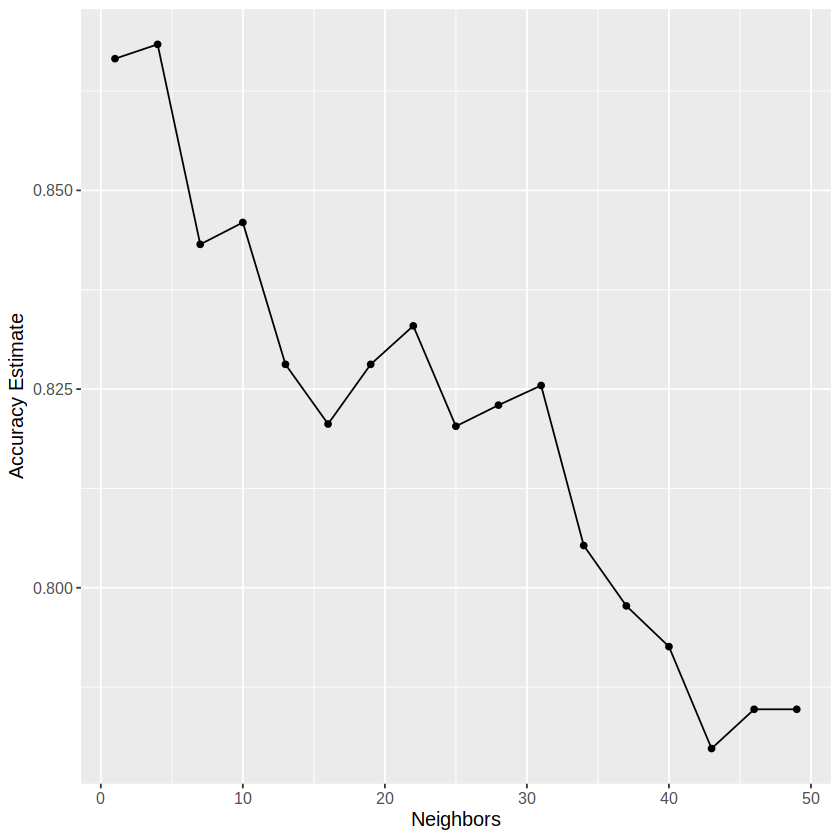

In [14]:
#then we plot the k vs accuracy and choose the k with highest accuracy

acc_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

options(rept.plot.width = 4, rept.plot.height = 4)

acc_vs_k

So at K = 4, we get the highest accuracy. 

#### Prediction using the chosen K

In [20]:
#Final model with K = 4
health_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode("classification")

#Reuse recipe and fit
health_fit_final <- workflow() |>
    add_recipe(health_recipe) |>
    add_model(health_spec_final) |>
    fit(health_training)

health_predictions <- predict(health_fit_final, health_testing) |>
    bind_cols(health_testing)

#Check accuracy of our model
health_predictions_accuracy <- health_predictions |>
    metrics(truth = fetal_health, estimate = .pred_class)
health_predictions_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8030303
kap,multiclass,0.7045455


Our model seems to be able to predict accurately 80% of the time. We do deeper analysis by creating bar graphs

#### Visualization and Analysis

`summarise()` has grouped output by 'correct'. You can override using the
`.groups` argument.


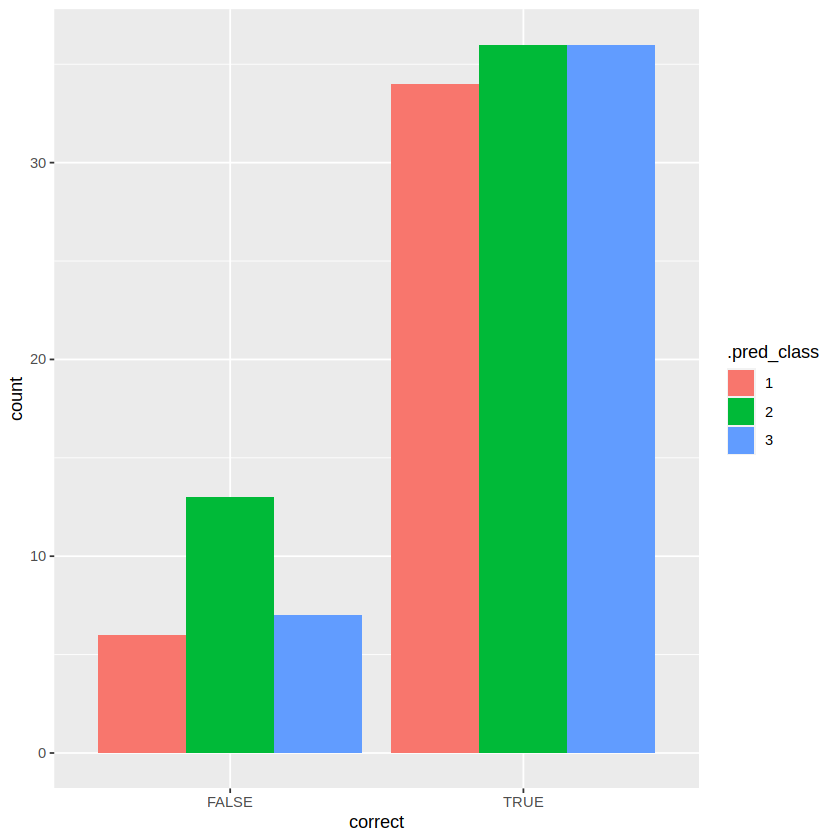

In [30]:
health_predictions_clean <- health_predictions |>
    select(.pred_class, fetal_health) |>
    mutate(correct = (.pred_class == fetal_health)) |>
    group_by(correct, .pred_class) |>
    summarize(count = n())

health_predictions_plot <- ggplot(health_predictions_clean, aes(x = correct, y = count, fill = .pred_class)) +
    geom_bar(stat = "identity", position = "dodge")

health_predictions_plot